## Depth First Search and Edge Classification

### If you're using Datahub:
* Run the cell below **and restart the kernel if needed**

In [2]:
# Install dependencies
!pip install -r requirements.txt --quiet

### Local setup instructions:
You'll need to perform some extra setup.
#### First-time setup
1. Install `uv` following the instructions here: https://docs.astral.sh/uv/getting-started/installation/. 
2. Create a virtual environment (venv) using `uv venv --python 3.11`. 
3. Activate the environment: 
    - If on macOS/Linux: `source .venv/bin/activate`
    - If on Windows: `.venv\Scripts\activate`
4. Install jupyter: `uv pip install jupyter`.
5. If you ever want to switch to a different environment, simply run the command `deactivate`. 

#### Every time you want to work
* `cd` to the directory which contains this notebook `cd /path/to/notebook-dir/`. 
* Make sure you've activated the venv: `source .venv/bin/activate` or `.venv\Scripts\activate` if on Windows.
* Launch jupyter: `jupyter notebook` or `jupyter lab`. You can also use directly VSCode's built in ipynb UI, which is quite nice and featureful (in which case you won't even need to activate the venv, you'll be prompted to select the kernel for the notebook, and then pick the venv you created).
* Run the cell below **and restart the kernel if needed**

In [3]:
# Install dependencies
!uv pip install -r requirements.txt --quiet

In [4]:
import otter
assert (
    otter.__version__ >= "5.5.0"
), "Please reinstall the requirements and restart your kernel."
import networkx as nx
import numpy as np
import tqdm
import pickle
grader = otter.Notebook("dfs-edge-classification.ipynb")

rng_seed = 0

In [5]:
# Load test cases
file_path = "generated_testcases.pkl"

# Load the variables from the pickle file
with open(file_path, "rb") as file:
    loaded_data = pickle.load(file)
file.close()
inputs, outputs = loaded_data

#### Representing graphs in code

There are multiple ways to represent graphs in code. In class we covered [adjacency matrices](https://people.eecs.berkeley.edu/~vazirani/algorithms/chap3.pdf#page=2) and [adjacency lists](https://people.eecs.berkeley.edu/~vazirani/algorithms/chap3.pdf#page=3). There is also the edge list representation, in which you store the edges in a single 1 dimensional list. In general for CS170 and in most cases, we choose to use the adjacency list representation since it allows us to efficiently search over a node's neighbors.

In many programming problems, verticies are typically labelled $0$ through $n-1$ for convenience (recall that arrays and lists in most languages begin at index 0). This allows us to represent an adjacency list using a list of lists that store ints. Given an edge list, the following code will create an adjacency list for an **unweighted directed graph**.

In [6]:
def generate_adj_list(n, edge_list):
    """ Generates an adjacency list given a set of edges.
    
    Args:
        n (int): Number of nodes in the graph. The nodes are labelled with integers 0 through n-1
        edge_list (list[tuple[int, int]]): Edge list where each tuple (u,v) represents the directed edge (u,v) in the graph.
        
    Returns:
        list[list[int]]: The adjacency list, where adj_list[u] = sorted([v for v in neighbors(u)])
    """
    adj_list = [[] for _ in range(n)] 
    for u, v in edge_list:
        adj_list[u].append(v)

    for u in range(n):
        adj_list[u] = sorted(adj_list[u])

    return adj_list

def draw_graph(adj_list):
    """ Utility method for visualizing graphs.

    Args:
        adj_list (list[list[int]]): Adjacency list of the graph given by generate_adj_list.

    Returns:
        None
    """
    G = nx.DiGraph()
    for u in range(len(adj_list)):
        for v in adj_list[u]:
            G.add_edge(u, v)
    nx.draw(G, with_labels=True)

## Q1: Reconstructing the DFS Path

In class we showed how to use DFS to check if there exists a path between two nodes, topologically sort nodes, and find SCCs. In those algorithms, pre and post numbers were used.

Here you'll implement a variation of DFS to print out the path between two nodes. In many problems, we want to be able to find the actual path between two nodes, not just determine if it exists. 

> ### **Task 1:** Compute a path from $s$ to $t$ using DFS and return the path as a list of nodes on that path. 

For example, the path ${s \to a \to b \to c \to t}$ corresponds to the list `[s, a, b, c, t]`. If no path exists, return the empty list `[]`.

You do not need to implement calculating pre and post numbers for this exercise.

*Hint:*
1. If you want to start with the recursive DFS implementation from DPV, you can use [mutable types or the `nonlocal` keyword](https://cs61a.org/study-guide/mutation/#local-state) to preserve state across recursive calls.
2. It may be helpful to maintain an extra data structure which tracks the previous node we visited each time we visit a new node. 

In [7]:
def dfs_path(adj_list, s, t):
    """ Finds a path from s to t using DFS or returns an empty list if no path exists.
    
    Args:
        adj_list (list[list[int]]): An adjacency list.
        s (int): An int representing the starting node.
        t (int): An int representing the destination node.

    Returns:
        list[int]: A list of nodes starting with s and ending with t representing an s to t path if it exists. 
                   Returns an empty list otherwise.
    """
    # This can be mutated to track state for explore, but you can delete them if you prefer a different approach.
    visited = set()
    prev = {}
    

    def explore(curr):
        """
        Implements the explore subroutine from DPV, which is used in DFS. feel free to delete this 
        function and use an alternative implementation if you prefer.

        Args:
            curr (int): The node currently being traversed.
        
        Returns:
            None
        """
        visited.add(curr)
        if curr == t:
            return True
        
        for n in adj_list[curr]:
            if n not in visited:
                prev[n] = curr
                if explore(n):
                    return True

        return False
    
    if not explore(s):
        return []

    path = [t]
    while path[-1] != s:
        parent = prev.get(path[-1])
        if parent is None:
            return []
        path.append(parent)
    path.reverse()
    return path

    

### Debugging

You can create sample tests in the following cells to help debug your solution. We provide a few small tests as an example, but they might not be comprehensive.

To add a new graph to the test, append a new edge list to `edge_lists` as shown in the next cell.  
__Remember that these edges are directed, so do not add both directions of an edge to the edge list.__

In [8]:
edge_lists = []
edge_lists.append([(0,1), (0,2), (1,2), (2,3), (3,4), (3,5), (4,5)])   # edge list of first graph
edge_lists.append([(0,1), (0,2), (1,2), (3,4), (3,5), (4,5)])          # edge list of second graph
# add any additional tests here

For each test case you also need to add a starting node $s$, a destination node $t$, and $n$ the number of nodes in the graph, add them to the following lists. 

In [9]:
s_list = []
s_list.append(0)  # s for first graph 
s_list.append(1)  # s for second graph 
# add any additional tests here

t_list = []
t_list.append(3)  # t for first graph
t_list.append(4)  # t for second graph
# add any additional tests here

n_list = []
n_list.append(6)  # n = 6 for first graph
n_list.append(6)  # n = 6 for second graph
# add any additional tests here

The following is a simplified version of the autograder, you may want to add more print statements or other debugging statements to check your function.

Testing graph: 1


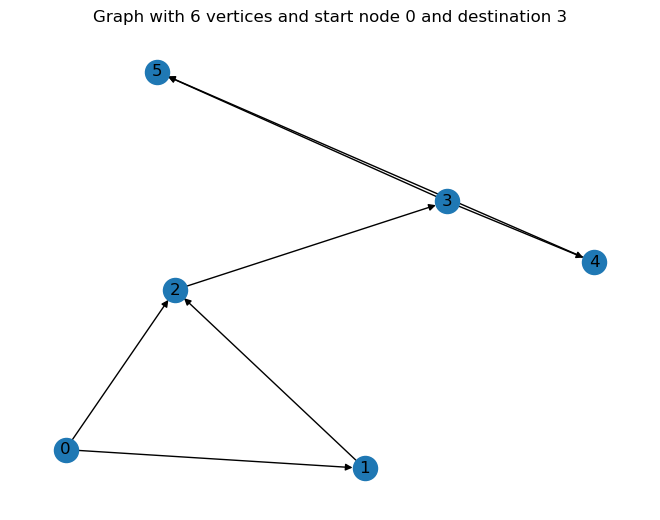

Testing graph: 2


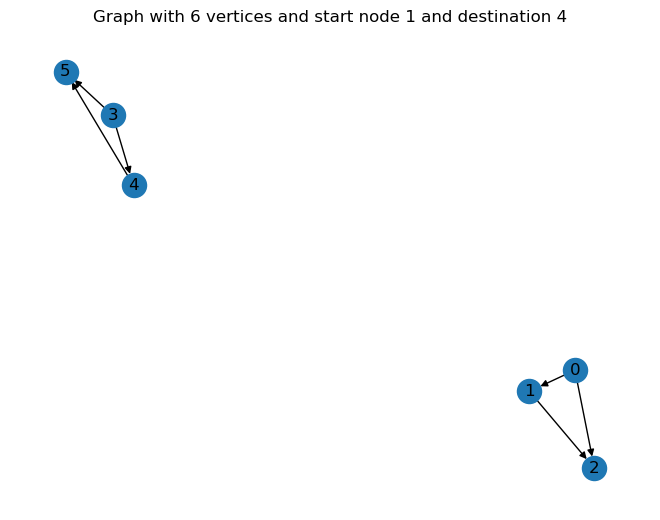

Success


In [10]:
import matplotlib.pyplot as plt
index = 1
for s, t, n, edge_list in zip(s_list, t_list, n_list, edge_lists):
    print("Testing graph:", index)
    index += 1
    
    adj_list_graph = generate_adj_list(n, edge_list) # function defined earlier
    # draw_graph(adj_list_graph)
    
    path = dfs_path(adj_list_graph, s, t) 
    
    nx_graph = nx.DiGraph(edge_list)
    
    # uncomment the following to plot each graph
    
    nx.draw(nx_graph, with_labels=True)
    plt.title(f"Graph with {n} vertices and start node {s} and destination {t}")
    plt.show()
    
    if not nx.has_path(nx_graph,s,t):
        assert len(path) == 0, f"your dfs_path found an s-t path when there isn't one."
    else:
        # checks that the path returned is a real path in the graph and that it starts and ends 
        # at the right vertices
        assert nx.is_simple_path(nx_graph, path), f"your dfs_path did not return a valid simple path"
        assert path[0] == s, f"your dfs_path returned a valid simple path, but it does not start at node s"
        assert path[-1] == t, f"your dfs_path returned a valid simple path, but it does not end at node t"

print("Success")

In [11]:
grader.check("q1")

100%|██████████| 50/50 [00:01<00:00, 31.67it/s] 


q1 results: All test cases passed!

## Q2: Pre and Post Numbers
In order to topologically sort or find strongly connected components, we need to be able to calculate pre and post numbers for each node. 

In this part, you will rework your implementation of DFS to allow it to generate pre and post order numbers for each node. It might be a good idea to copy/paste your solution from the previous part and modify it here. 

> ### **Task 2:** Implement a function that computes DFS pre and post numbers for each node in the graph.

To pass the autograder, your smallest preorder number should be 1. Your largest postorder number should be $ 2 \times \text{(number of vertices)}$. Return two lists of tuples, a `pre` list containing tuples `(node, pre-number)`, and a `post` list containing tuples `(node, post-number)`. 

Both lists should be ordered according to the pre/post number in the tuple. **You should not use any sorting functions to accomplish this!**

> ### **Reflect:** Why might returning pre/post numbers in this way be helpful for finding strongly connected components?

Feel free to delete the starter code and implement your own solution. 
> **Note**: The recursive implementation is simpler than the iterative solution, so we suggest that you only come back to try the iterative solution once you've completed the rest of the assignment!

For this part, you can no longer assume that the entire graph is guaranteed to be reachable from some certain start node. How will this change your implementation?

Finally, break ties by choosing the node with the smallest number value. The autograder may fail implementations which are otherwise correct but break ties in a different way.

In [16]:
def get_pre_post(adj_list):
    """ Computes pre and post numbers for each node in the graph.
    
    Args:
        adj_list (list[list[int]]): The adjacency list that represents our input graph.
        
    Returns:
        list[tuple[int, int]], list[tuple[int, int]]: The pre and post order values respectively.
            Each tuple should have a vertex as its first entry, and the pre/post order value as its second entry.
    """
    time = [1] # This is to make sure the time counter is global mutable state. You can use nonlocal if you'd prefer!
    pre = []
    post = []
    visited = set()
    

    # YOUR CODE HERE
    def explore(curr):
        """
        Implements the explore subroutine from DPV, which is used in DFS. feel free to delete this 
        function and use an alternative implementation if you prefer.

        Args:
            curr (int): The node currently being traversed.
        
        Returns:
            None
        """
        visited.add(curr)
        pre.append((curr, time[0]))
        time[0] += 1
        for n in adj_list[curr]:
            if n not in visited:
                explore(n)
        post.append((curr, time[0]))
        time[0] += 1
    
    
    n = len(adj_list)
    for node in range(n):
        if node not in visited:
            explore(node)

    return pre, post

In [17]:
grader.check("q2")

100%|██████████| 110/110 [00:00<00:00, 1225.60it/s]


q2 results: All test cases passed!

## Q3: Identifying Tree, Forward, Back, Cross Edges

As we perform DFS traversals and create DFS trees and DFS forests within our graph, we would like to classify our edges according to how they appear in the resulting DFS forest. These classifications can provide us with insights about our graph. For example, the presence of a back edge $(u, v)$ tells us that we have a cycle within this graph that includes all the tree edges on the path from v to u and the back edge $(u, v)$.
> ### **Task 3:** Given the adjacency list of a graph, add each edge present in the edge set to the correct classification according the DFS traversal you implemented in part 1.

**Don't modify the initialization of the edges_lookup dictionary.**

In [20]:
def categorize_edges(adj_list):
    """ Categorizes all edges of the graph.
    
    Args:
        adj_list (list[list[int]]): The adjacency list that represents our input graph.
        
    Returns:
        A dictionary with the following schema:
        {
            'tree': set[tuple[int, int]],
            'forward': set[tuple[int, int]],
            'cross': sset[tuple[int, int]],
            'back': set[tuple[int, int]],
        }, 
        where each set contains the edges that belong to the corresponding edge type specified by the key (e.g. 'tree')
    """
    edges_lookup = {
        'tree': set(),
        'forward': set(),
        'cross': set(),
        'back': set()
    }
    visited = set()
    pre = {}
    post = {}
    time = [1]

    def explore(u):
        visited.add(u)
        pre[u] = time[0]
        time[0] += 1
        for v in adj_list[u]:
            if v not in visited:
                edges_lookup['tree'].add((u, v))
                explore(v)
        post[u] = time[0]
        time[0] += 1

    for node in range(len(adj_list)):
        if node not in visited:
            explore(node)
            
    for u in range(len(adj_list)):
        for v in adj_list[u]:
            if (u, v) in edges_lookup['tree']: # tree edge
                continue
            if pre[v] < pre[u] and post[u] < post[v]:
                edges_lookup['back'].add((u, v)) # back edge
            elif pre[u] < pre[v] and post[v] < post[u]:
                edges_lookup['forward'].add((u, v)) # forward edge
            else:
                edges_lookup['cross'].add((u, v)) # cross edge

    return edges_lookup

In [21]:
grader.check("q3")

100%|██████████| 100/100 [00:00<00:00, 1287.22it/s]


q3 results: All test cases passed!

## Submission

Make sure you have run all cells in your notebook in order before running the cell below, so that all images/graphs appear in the output. The cell below will generate a zip file for you to submit.

In [ ]:
grader.export(pdf=False, force_save=True, run_tests=True)